In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from datetime import timedelta
from dotenv import find_dotenv
from os.path import dirname
from os.path import exists
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.load import load_train_df
from src.load import load_test_df
from src.transform import get_week_by_dept_df
from src.transform import unpivot_week_by_dept_df
from src.transform import svd_reconstruct
from src.features import make_id_column

# Root directory of repo
project_dir = dirname(find_dotenv())

# Use custom matplotlib style
plt.style.use(join(project_dir, 'big-darkgrid.mplstyle'))

In [8]:
week_by_dept = get_week_by_dept_df()
week_by_dept.tail()

Store_Dept,10_1,10_10,10_11,10_12,10_13,10_14,10_16,10_17,10_18,10_19,...,9_9,9_90,9_91,9_92,9_93,9_94,9_95,9_96,9_97,9_98
Date,,,,,,,,,,,,,,,,,,,,,
2012-09-28,31477.50,47821.03,23483.55,8628.64,56960.17,30545.42,17398.02,22918.62,11069.68,2930.77,...,16044.45,3156.76,998.95,18333.69,34.9,84.80,33119.87,3763.21,-9.92,6.0
2012-10-05,36323.95,46511.89,26447.16,9423.35,64940.04,34453.61,16204.14,25257.58,16151.92,2968.35,...,17044.07,2954.65,889.74,20612.82,34.9,158.98,35189.41,4306.43,-9.92,6.0
2012-10-12,40626.47,48684.03,25425.08,9051.76,61065.21,33971.87,12939.16,24494.83,19251.31,3440.85,...,13830.42,3151.12,698.84,20285.74,34.9,3.88,32072.80,3675.99,-9.92,6.0
2012-10-19,44224.36,46947.21,25507.61,8245.89,58976.21,38299.34,15007.93,25287.66,22814.92,2955.10,...,12813.42,3126.61,923.60,19304.95,34.9,23.28,34031.01,3540.05,-9.92,6.0
2012-10-26,58409.83,43637.06,25448.11,9043.49,61010.32,31883.89,11397.55,24781.75,27426.84,3271.02,...,14034.40,3096.77,914.84,18310.28,34.9,233.02,32382.05,4752.25,-9.92,6.0


In [12]:
week_by_dept2 = week_by_dept.shift(52)
week_by_dept2.tail()

Store_Dept,10_1,10_10,10_11,10_12,10_13,10_14,10_16,10_17,10_18,10_19,...,9_9,9_90,9_91,9_92,9_93,9_94,9_95,9_96,9_97,9_98
Date,,,,,,,,,,,,,,,,,,,,,
2012-09-28,31654.83,46741.08,25135.31,8310.16,59617.80,35202.53,21897.09,23126.69,6143.18,2633.95,...,12578.37,3458.26,869.74,15518.36,34.9,64.74,31523.74,3340.16,-9.92,1.5
2012-10-05,37294.04,53097.86,27620.13,8721.13,65464.57,38471.29,18724.89,24676.70,11242.89,3458.37,...,12801.80,3588.95,959.68,18602.41,34.9,54.78,33160.67,4454.78,-9.92,1.5
2012-10-12,39680.90,48159.92,25699.35,9013.73,61492.40,33037.26,15496.18,23395.02,15147.58,2960.40,...,11708.71,3406.68,817.41,17133.10,34.9,109.08,30064.47,4116.66,-9.92,1.5
2012-10-19,47792.75,46021.91,25911.42,9252.23,60363.04,33683.18,11785.44,24959.53,17692.57,3047.53,...,10956.27,3424.57,880.93,16482.22,34.9,214.14,30402.54,4181.56,-9.92,6.0
2012-10-26,68491.28,43216.33,25940.74,9890.17,58593.28,31908.74,8328.67,23611.19,26935.41,3798.81,...,9286.45,3354.83,515.51,17124.85,34.9,363.54,29126.08,3304.87,-9.92,18.0


In [13]:
week_by_dept = get_week_by_dept_df()
shifted_dfs = []
for i in [51, 52, 53]:
    new_df = week_by_dept.shift(i)
    shifted_dfs.append(new_df)
#     new_df.columns = ["{}_{}".format(c, i) for c in shifted_dfs.columns]

In [14]:
unpivoteds = []
for df in [week_by_dept] + shifted_dfs:
    unpivoted = unpivot_week_by_dept_df(df)
    unpivoted = make_id_column(unpivoted)
    unpivoted = unpivoted.set_index('Id', drop=True)
    unpivoteds.append(unpivoted)

In [15]:
df_train = unpivoteds[0].copy()
for df in shifted_dfs:
    # Combine the columns from the shifted dataframes together in one dataframe, so
    # each point has several values from around a year ago to train on

,Date,Store_Dept,Weekly_Sales
Id,,,
10_1_2010-02-05,2010-02-05,10_1,40212.84
10_1_2010-02-12,2010-02-12,10_1,67699.32
10_1_2010-02-19,2010-02-19,10_1,49748.33
10_1_2010-02-26,2010-02-26,10_1,33601.22
10_1_2010-03-05,2010-03-05,10_1,36572.44


In [6]:

i
week_by_dept.tail()

Store_Dept,10_1,10_10,10_11,10_12,10_13,10_14,10_16,10_17,10_18,10_19,...,9_9,9_90,9_91,9_92,9_93,9_94,9_95,9_96,9_97,9_98
Date,,,,,,,,,,,,,,,,,,,,,
2012-09-28,31477.50,47821.03,23483.55,8628.64,56960.17,30545.42,17398.02,22918.62,11069.68,2930.77,...,16044.45,3156.76,998.95,18333.69,34.9,84.80,33119.87,3763.21,-9.92,6.0
2012-10-05,36323.95,46511.89,26447.16,9423.35,64940.04,34453.61,16204.14,25257.58,16151.92,2968.35,...,17044.07,2954.65,889.74,20612.82,34.9,158.98,35189.41,4306.43,-9.92,6.0
2012-10-12,40626.47,48684.03,25425.08,9051.76,61065.21,33971.87,12939.16,24494.83,19251.31,3440.85,...,13830.42,3151.12,698.84,20285.74,34.9,3.88,32072.80,3675.99,-9.92,6.0
2012-10-19,44224.36,46947.21,25507.61,8245.89,58976.21,38299.34,15007.93,25287.66,22814.92,2955.10,...,12813.42,3126.61,923.60,19304.95,34.9,23.28,34031.01,3540.05,-9.92,6.0
2012-10-26,58409.83,43637.06,25448.11,9043.49,61010.32,31883.89,11397.55,24781.75,27426.84,3271.02,...,14034.40,3096.77,914.84,18310.28,34.9,233.02,32382.05,4752.25,-9.92,6.0


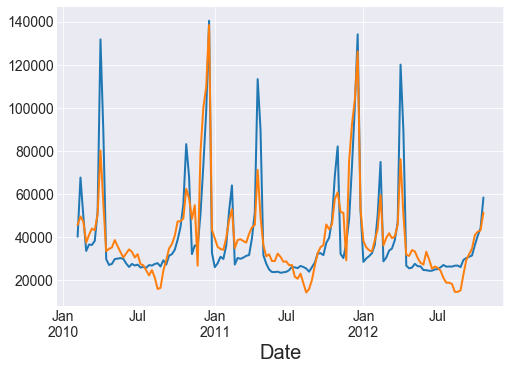

In [35]:
df2 = svd_reconstruct(d, n_comp=5)
fig, ax = plt.subplots()
d['10_1'].plot(ax=ax)
df2['10_1'].plot(ax=ax)
plt.show()

In [34]:
class RandomForestModel():
    def __init__(self, fillna_method='interpolate', return_pivoted=False,
                 svd=True, n_comp=10):
        self.model_dict = {}
        self.fillna_method = fillna_method
        self.svd = svd
        self.return_pivoted = return_pivoted
        self.n_comp = n_comp

    def fit_predict(self, X_train, X_test):
        self.week_by_dept = get_week_by_dept_df(X_train)
        X_test = make_id_column(X_test)
        pred_week_by_dept = get_week_by_dept_df(X_test, fillna_method=None, values=None)
        if self.svd:
            self.week_by_dept = svd_reconstruct(self.week_by_dept,
                                                n_comp=self.n_comp)
        for c in pred_week_by_dept.columns:
            if c in self.week_by_dept.columns:
                ts = self.week_by_dept[c]
            else:
                ts = self.week_by_dept.mean(axis=1)
            import warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = SARIMAX(
                    ts, trend='n', order=(0,1,0), seasonal_order=(0,1,0,52)
                ).fit(disp=0)
            start = len(self.week_by_dept)
            end = start + len(pred_week_by_dept)
            y_pred = model.predict(start=start, end=end, dynamic=True) 
            pred_week_by_dept[c] = y_pred

        if self.return_pivoted:
            return pred_week_by_dept
        else:
            unpivoted = unpivot_week_by_dept_df(pred_week_by_dept)
            unpivoted = make_id_column(unpivoted)
            unpivoted = unpivoted.set_index('Id', drop=True)
            unpivoted = unpivoted.reindex(X_test['Id'])
            return unpivoted['Weekly_Sales']

My ARIMA model is performing slowly, so I'll just train and predict Store 1.

In [10]:
full_train_df = load_train_df()
full_train_df = full_train_df[full_train_df['Store']==1]
split_date = full_train_df['Date'].min() + timedelta(weeks=104)
train_df = full_train_df[full_train_df['Date']<split_date]
test_df = full_train_df[full_train_df['Date']>=split_date]
test_df = make_id_column(test_df).set_index('Id', drop=True)
test_df, y_actual = test_df[['Store', 'Dept', 'Date', 'IsHoliday']], test_df['Weekly_Sales']

In [11]:
full_train_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Store_Dept
10239,1,99,2012-08-31,20.06,False,1_99
10240,1,99,2012-09-07,0.05,True,1_99
10241,1,99,2012-09-14,0.03,False,1_99
10242,1,99,2012-10-05,635.00,False,1_99
10243,1,99,2012-10-12,80.00,False,1_99


In [ ]:
%%time
y_preds = []
for n_comp in [1, 5, 10, 50]:
    print("Doing n_comp =", n_comp)
    am = ArimaModel(svd=True, n_comp=n_comp)
    y_pred = am.fit_predict(train_df, test_df)
    y_preds.append(y_pred)

Doing n_comp = 1


In [31]:
full_train_df['Dept'].nunique()

77

In [50]:
# from http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52).mean()
    rolstd = timeseries.rolling(window=52).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

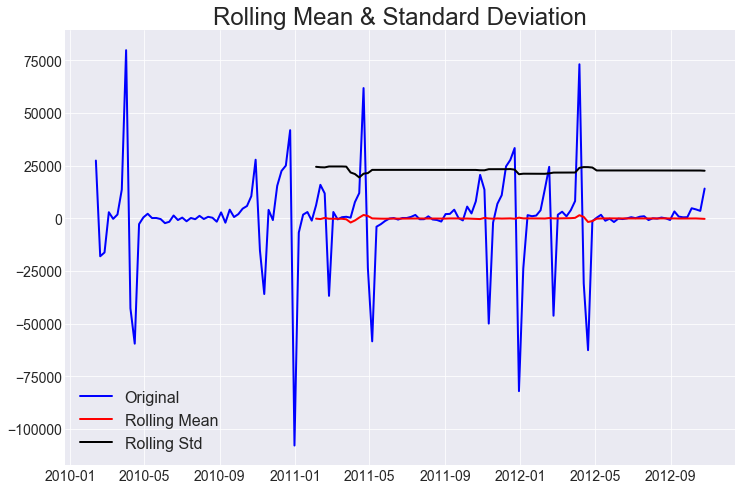

Results of Dickey-Fuller Test:
Test Statistic                -9.935376e+00
p-value                        2.752621e-17
#Lags Used                     5.000000e+00
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


In [53]:
first_difference = one_dept - one_dept.shift(1)
test_stationarity(first_difference.dropna())

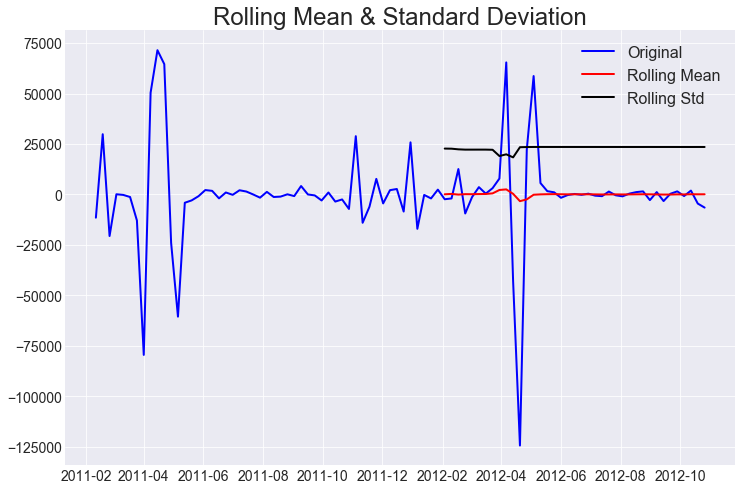

Results of Dickey-Fuller Test:
Test Statistic                -7.408643e+00
p-value                        7.231821e-11
#Lags Used                     5.000000e+00
Number of Observations Used    8.400000e+01
Critical Value (1%)           -3.510712e+00
Critical Value (5%)           -2.896616e+00
Critical Value (10%)          -2.585482e+00
dtype: float64


In [54]:
seasonal_first_difference = first_difference - first_difference.shift(52)
test_stationarity(seasonal_first_difference.dropna())

In [55]:
result = seasonal_decompose(week_by_dept, freq=52)

In [57]:
result.seasonal.head()

Store_Dept,10_1,10_10,10_11,10_12,10_13,10_14,10_16,10_17,10_18,10_19,...,9_9,9_90,9_91,9_92,9_93,9_94,9_95,9_96,9_97,9_98
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,-4638.774405,-5282.793141,-1045.830848,-665.875286,2099.679303,1306.153390,-4653.014951,1858.617990,-10962.490267,-138.857457,...,-4394.082526,-43.306805,-287.969332,65.049265,-0.161657,-216.406235,-2978.636359,86.786255,3.306741,-4.727764
2010-02-12,10350.377759,1122.686138,-2859.289406,360.722791,3423.050553,4832.977910,-3540.186105,5588.418134,-381.812126,-85.900005,...,-5457.652574,-149.227766,-524.230293,557.162775,-0.161657,1043.236754,-4420.385926,-617.088024,3.201768,-4.552284
2010-02-19,28561.039442,4175.101186,-3678.018829,367.117743,2363.482620,3526.099448,-534.503605,3721.444865,11974.978618,-643.305485,...,-1821.945507,-136.970555,-341.674428,-1104.183043,-0.161657,3204.439871,-4584.834388,-791.206005,3.082799,-4.376803
2010-02-26,-12898.295270,3316.950705,-2220.319454,1463.648753,6370.807091,2831.826852,458.923847,5680.597317,-14533.328035,225.617303,...,-1918.769737,-29.836516,-240.778370,-1529.153043,-0.161657,1351.532299,-5352.432657,-974.690572,2.949833,-4.201322
2010-03-05,-10462.194357,2156.860561,-2504.436809,516.946589,5701.137813,5147.023967,1906.146732,3885.198615,-15000.799941,5.797351,...,-679.729786,-27.158728,-96.419380,-911.352947,-0.161657,1043.607371,-2865.399869,-942.130332,2.802871,-4.025841


In [86]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df_pred = pd.DataFrame(index=week_by_dept.index[104:])
for c in week_by_dept.columns[:2]:
    model = SARIMAX(week_by_dept[c].iloc[:104], trend='n', order=(0,1,0),
                    seasonal_order=(0,1,0,52))
    results = model.fit()
    y_pred = results.predict(start=104, end=len(week_by_dept), dynamic= True) 
    df_pred[c] = y_pred

/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


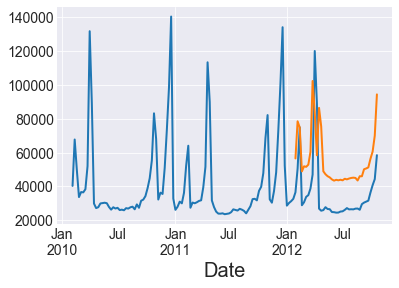

In [77]:
fig, ax = plt.subplots()
y_pred = pd.Series(y_pred, index=one_dept.index[104:])
one_dept.plot(ax=ax)
y_pred.plot(ax=ax)

In [30]:
from statsmodels.tsa.arima_model import ARIMA
X = week_by_dept.iloc[:, 0]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
model = ARIMA(train, order=(0,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=len(test))
predictions = output[0]

/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple s

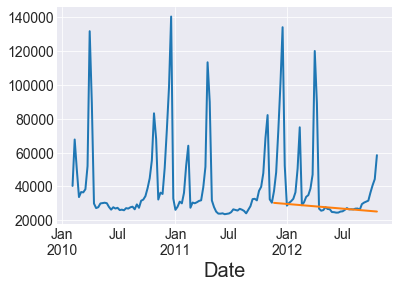

In [31]:
fig, ax = plt.subplots()
X.plot(ax=ax)
y_pred = pd.Series(predictions, index=test.index)
y_pred.plot(ax=ax)

In [21]:
from statsmodels.tsa.arima_model import ARIMA
X = week_by_dept.iloc[:, 0]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/benlindsay/miniconda/envs/altakehome/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

predicted=30167.706882, expected=37228.540000
predicted=37196.792128, expected=48269.300000
predicted=48354.104842, expected=72970.200000
predicted=73311.422500, expected=100775.800000
predicted=101400.160412, expected=134217.740000
predicted=135176.973673, expected=52228.860000
predicted=52350.233939, expected=28520.490000
predicted=28403.566500, expected=30107.310000
predicted=30007.255248, expected=31180.230000
predicted=31091.675000, expected=32559.130000
predicted=32484.822136, expected=36444.000000
predicted=36407.761154, expected=50434.110000
predicted=50531.455429, expected=74930.330000
predicted=75257.853491, expected=28751.570000
predicted=28644.455327, expected=30525.880000
predicted=30436.185926, expected=33728.460000
predicted=33668.970275, expected=34745.100000
predicted=34695.393273, expected=38656.880000
predicted=38642.862341, expected=46922.970000
predicted=46982.881875, expected=120131.350000
predicted=120838.593451, expected=89291.510000
predicted=89722.024649, expe

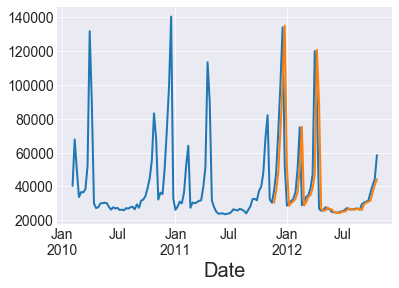

In [24]:
fig, ax = plt.subplots()
X.plot(ax=ax)
y_pred = pd.Series(predictions, index=test.index)
y_pred.plot(ax=ax)

TypeError: Empty 'DataFrame': no numeric data to plot

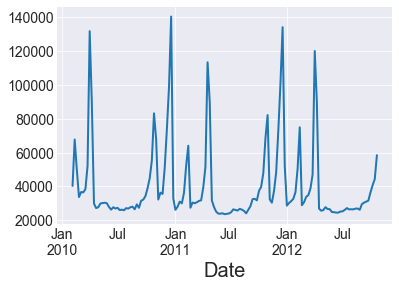

In [19]:
# df = pd.DataFrame({'pred': predictions, 'actual': history}, index=test.index)
# df.plot(ax=ax)
plt.show()

# Baseline Models

Let's look at some simple ways we could model this problem to get a baseline to build from. One way to get pretty far with seasonal data like this is to look at past values and either pick the most recent value from that date or average all the data from past matching dates.

In [3]:
week_by_dept_df = get_week_by_dept_df()
week_by_dept_df.head()

Store_Dept,10_1,10_10,10_11,10_12,10_13,10_14,10_16,10_17,10_18,10_19,...,9_9,9_90,9_91,9_92,9_93,9_94,9_95,9_96,9_97,9_98
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,40212.84,48027.87,36705.57,10365.86,74020.63,55033.94,25694.43,36872.18,8912.27,4046.34,...,7245.32,2335.92,292.64,11620.09,7.58,982.500000,23292.10,2438.08,668.48,1.5
2010-02-12,67699.32,50595.72,31052.34,9375.25,69145.42,51167.46,24555.89,34782.91,28176.35,3602.73,...,6556.94,2486.18,544.74,11080.50,7.58,982.500000,22317.38,2304.09,766.93,1.5
2010-02-19,49748.33,51199.72,33224.65,11032.90,68060.96,49011.24,33321.92,34512.54,16244.14,3617.85,...,7301.19,2452.70,424.26,10233.49,7.58,2163.750000,20694.32,1944.11,607.02,1.5
2010-02-26,33601.22,50028.83,29268.91,11058.90,71517.99,49829.71,27773.67,31175.51,916.25,4207.51,...,7814.18,2386.49,470.43,10786.42,7.58,2059.545455,21780.08,2423.55,580.74,1.5
2010-03-05,36572.44,49892.15,31934.99,11033.07,70279.43,46865.98,35227.56,33143.03,1426.47,3623.52,...,10540.89,2369.01,679.47,11176.21,7.58,1955.340909,22187.57,2591.28,371.05,1.5


The dates don't line up perfectly year-by-year, so let's see if just shifting by 52 rows works. 

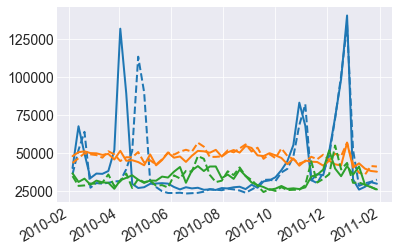

In [4]:
index = week_by_dept_df.index[:52]
for i in range(3):
    l, = plt.plot(index, week_by_dept_df.iloc[:52, i])
    plt.plot(index, week_by_dept_df.iloc[52:104, i], '--', color=l.get_color())
plt.gcf().autofmt_xdate()
plt.show()

The solid lines below are for the year starting in Feb. 2010, and the dashed lines are for the corresponding dates from the next 52 rows. Christmas and Halloween line up well, and Easter doesn't but that's because it was the 4th in 2010 and the 24th in 2011. So this looks good.

Before making a baseline, let's set up our evaluation function as described [here](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting#evaluation).

In [5]:
def wmae(y_pred, y_actual, is_holiday=None, holiday_weight=5):
    if is_holiday is None:
        test_df = load_test_df()
        is_holiday = test_df['IsHoliday']
    n = len(y_pred)
    assert(n == len(y_actual))
    assert(n == len(is_holiday))
    weights = np.ones(n)
    weights[is_holiday] = holiday_weight
    return 1.0 / np.sum(weights) * np.sum(weights * np.abs(y_actual - y_pred))

In [6]:
class PrevYearBaseline():
    def __init__(self, fillna_method='interpolate'):
        self.fillna_method = fillna_method
    
    def fit(self, X):
        """Given X with columns 'Store', 'Dept', 'Date', and 'Weekly_Sales',
        save data to be accessed by predict
        """
        self.week_by_dept = get_week_by_dept_df(X, fillna_method=self.fillna_method)
    
    def predict(self, X, return_pivoted=False):
        """Given X with columns 'Store', 'Dept', and 'Date', predict 'Weekly_Sales'
        """
        X = make_id_column(X)
        pred_week_by_dept = get_week_by_dept_df(X, fillna_method=None, values=None)
        for c in pred_week_by_dept.columns:
            if c not in self.week_by_dept.columns:
                self.week_by_dept[c] = self.week_by_dept.mean(axis=1)
        
        copy_week_by_dept = self.week_by_dept[pred_week_by_dept.columns.tolist()].copy()
        copy_week_by_dept.index += timedelta(weeks=52)
        pred_week_by_dept = copy_week_by_dept.loc[pred_week_by_dept.index]
        if return_pivoted:
            return pred_week_by_dept
        else:
            unpivoted = unpivot_week_by_dept_df(pred_week_by_dept)
            unpivoted = make_id_column(unpivoted)
            unpivoted = unpivoted.set_index('Id', drop=True)
            unpivoted = unpivoted.reindex(X['Id'])
            return unpivoted['Weekly_Sales']

In [7]:
full_train_df = load_train_df()
split_date = full_train_df['Date'].min() + timedelta(weeks=104)
train_df = full_train_df[full_train_df['Date']<split_date]
test_df = full_train_df[full_train_df['Date']>=split_date]
test_df = make_id_column(test_df).set_index('Id', drop=True)
test_df, y_actual = test_df[['Store', 'Dept', 'Date', 'IsHoliday']], test_df['Weekly_Sales']

In [8]:
bl = PrevYearBaseline()
bl.fit(train_df)
y_pred = bl.predict(test_df)

Error on holdout set on last 39 weeks of data trained on 2 years of data:

In [9]:
wmae(y_pred, y_actual, test_df['IsHoliday'])

1811.0863308312692

# Check score on Kaggle

In [10]:
bl = PrevYearBaseline()
test_df = load_test_df()
bl.fit(full_train_df)
y_pred = bl.predict(test_df)

In [11]:
file_path = join(project_dir, 'data/processed/baseline_kaggle_sub.csv')
if not exists(file_path):
    y_pred.to_csv(file_path, index=True, header=True)

This submission from just looking at last year's value gave a score of 2951, which would put me in position 181 out of 691.